# Explainable machine learning for project control

# Backward analysis

In [21]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
#!pip install -q shap

In [ ]:
import shap
import matplotlib.pyplot as plt
print('SHAP version:',shap.__version__)

In [ ]:
# Load JS (requiered for showing plots)
shap.initjs()

## Monte-Carlo simulation dataset
A case study based on Lambrechts (2008)

<img src='https://drive.google.com/uc?id=1-bCEgplDUqbRSO0NW7stGbLa9xI3DX81' width="400" align="left"/>
<img src='https://drive.google.com/uc?id=1JLt90ba0QGqV8yKzDu0-T-yZTB9-u0lW' width="500" align="left"/>

In [22]:
# Simulation  dataset
# Null model (5-rand) of comparison
dfsim_5_rand=pd.read_csv('./data/simulation_EV0.75_5-rand.csv',index_col=0)
dfsim_5_rand['critical_path']=dfsim_5_rand['critical_path'].astype('str')
# Interaction between activities 2-5
dfsim_2_5=pd.read_csv('./data/simulation_EV0.75_2-5.csv',index_col=0)
dfsim_2_5['critical_path']=dfsim_2_5['critical_path'].astype('str')

### Study point

In [ ]:
# Chose a point where A2 tirggers the change in the A5 normal distribution
# Random instance with A5's duration greater than the threshold
# th=18-2*np.sqrt(0.83) # threshold
# sp_j=dfsim_2_5[dfsim_2_5['duration5']>th].sample(1).index[0]
# sp_j=28656
# study_point=dfsim_2_5.loc[sp_j,:].to_frame().T
# study_point.to_csv('./data/study_point.csv')
study_point=pd.read_csv('./data/study_point.csv',index_col=0)
study_point

## DBAC regression
DBAC~ {activity i's duration at 75%EV} i=1,...,8

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [24]:
# random seed
seed=1123

### Gradient Boosting Regressor


In [25]:
# Regression models for dbac (1)
mdr_dbac={'5-rand':GradientBoostingRegressor(max_depth=3, n_estimators=100,random_state=seed),
     '2-5':GradientBoostingRegressor(max_depth=3, n_estimators=100,random_state=seed)}

In [8]:
# Regression models for dbac (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  # regression ouput and input variables
  y=data.loc[:,'duration']
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  # Train the model
  mdr_dbac[simulation].fit(X,y)
  print('MSE(%s): %0.4f' % (simulation,mean_squared_error(y,mdr_dbac[simulation].predict(X))))

MSE(5-rand): 6.0986
MSE(2-5): 0.4752


In [9]:
# Save models
for simulation in ['5-rand','2-5']:
  pickle.dump(mdr_dbac[simulation], open('./data/mdr_backward_dbac_' + simulation + '.pkl', 'wb'))

In [6]:
# Load models
for simulation in ['5-rand','2-5']:
  mdr_dbac[simulation]=pickle.load(open('./data/mdr_backward_dbac_' + simulation + '.pkl', 'rb'))

### Shapley values

In [ ]:
# Shapley values (1)
shap_values_dbac=dict()
explainer_dbac=dict()

In [ ]:
# Shapley values (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  explainer_dbac.update({simulation:shap.Explainer(mdr_dbac[simulation])})
  shap_values_dbac.update({simulation:explainer_dbac[simulation](X)})
  shap_values_dbac[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

In [ ]:
# save
for simulation in ['5-rand','2-5']:
  pickle.dump(explainer_dbac[simulation], open('./data/explainer_backward_dbac_' + simulation + '.pkl', 'wb'))
  pickle.dump(shap_values_dbac[simulation], open('./data/shap_values_backward_dbac_' + simulation + '.pkl', 'wb'))

In [ ]:
# load
for simulation in ['5-rand','2-5']:
  explainer_dbac[simulation]=pickle.load(open('./data/explainer_backward_dbac_' + simulation + '.pkl', 'rb'))
  shap_values_dbac[simulation]=pickle.load(open('./data/shap_values_backward_dbac_' + simulation + '.pkl', 'rb'))

### Shapley plots

In [7]:
# Regression models for tb analysis (1)
mdr_tb={'5-rand':GradientBoostingRegressor(max_depth=5, n_estimators=1000,random_state=seed),
     '2-5':GradientBoostingRegressor(max_depth=5, n_estimators=1000,random_state=seed)}

In [12]:
# Regression models for tb (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  # regression ouput and input variables
  y=data.loc[:,'duration@']
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  # Train the model
  mdr_tb[simulation].fit(X,y)
  print('MSE(%s): %0.4f' % (simulation,mean_squared_error(y,mdr_tb[simulation].predict(X))))

MSE(5-rand): 0.0002
MSE(2-5): 0.0002


In [13]:
# Save models
for simulation in ['5-rand','2-5']:
  pickle.dump(mdr_tb[simulation], open('./data/mdr_tb_' + simulation + '.pkl', 'wb'))

In [8]:
# Load models
for simulation in ['5-rand','2-5']:
  mdr_tb[simulation]=pickle.load(open('./data/mdr_tb_' + simulation + '.pkl', 'rb'))

SHAP version: 0.39.0


### Compute Shapley values

In [12]:
# Shapley values - dbac regression (1)
shap_values_dbac=dict()
explainer_dbac=dict()

In [19]:
# Shapley values - dbac regression (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  explainer_dbac.update({simulation:shap.Explainer(mdr_dbac[simulation])})
  shap_values_dbac.update({simulation:explainer_dbac[simulation](X)})
  shap_values_dbac[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]


In [20]:
# save
for simulation in ['5-rand','2-5']:
  pickle.dump(explainer_dbac[simulation], open('./data/explainer_dbac_' + simulation + '.pkl', 'wb'))
  pickle.dump(shap_values_dbac[simulation], open('./data/shap_values_dbac_' + simulation + '.pkl', 'wb'))

In [13]:
# load
for simulation in ['5-rand','2-5']:
  explainer_dbac[simulation]=pickle.load(open('./data/explainer_dbac_' + simulation + '.pkl', 'rb'))
  shap_values_dbac[simulation]=pickle.load(open('./data/shap_values_dbac_' + simulation + '.pkl', 'rb'))

In [14]:
# Shapley values - tb regression (1)
shap_values_tb=dict()
explainer_tb=dict()

In [23]:
# Shapley values - tb regression (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  explainer_tb.update({simulation:shap.Explainer(mdr_tb[simulation])})
  shap_values_tb.update({simulation:explainer_tb[simulation](X)})
  shap_values_tb[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

In [24]:
# save
for simulation in ['5-rand','2-5']:
  pickle.dump(explainer_tb[simulation], open('./data/explainer_tb_' + simulation + '.pkl', 'wb'))
  pickle.dump(shap_values_tb[simulation], open('./data/shap_values_tb_' + simulation + '.pkl', 'wb'))

In [15]:
# load
for simulation in ['5-rand','2-5']:
  explainer_tb[simulation]=pickle.load(open('./data/explainer_tb_' + simulation + '.pkl', 'rb'))
  shap_values_tb[simulation]=pickle.load(open('./data/shap_values_tb_' + simulation + '.pkl', 'rb'))

## Forward analysis

In [107]:
# Chose a point where A2 tirggers the change in the A5 normal distribution
# Random instance with A5's duration greater than the threshold
th=18-2*np.sqrt(0.83) # threshold
#th=4+np.sqrt(0.83) # threshold
sp_j=dfsim_2_5[dfsim_2_5['duration5']>th].sample(1).index[0]
sp_j=28656
study_point=dfsim_2_5.loc[sp_j,:].to_frame().T
study_point.to_csv('./data/study_point.csv')
print('instance %i' %sp_j)
study_point

instance 28656


,duration1,duration2,duration3,duration4,duration5,duration6,duration7,duration8,duration@1,duration@2,...,duration@4,duration@5,duration@6,duration@7,duration@8,cost@,duration@,cost,duration,critical_path
28656,1.589067,5.167076,7.719155,2.89666,17.757242,3.895929,9.127317,2.517356,1.589067,5.167076,...,2.89666,4.51667,1.964591,5.198019,0.0,20770.922395,9.683746,27702.749577,22.924318,259


In [108]:
# Shaplet values of the study point for all regression models
study_point_shap_values_dbac=dict()
study_point_explainer_dbac=dict()
study_point_shap_values_tb=dict()
study_point_explainer_tb=dict()

# Shapley values - dbac regression
for simulation in ['5-rand','2-5']:
  X=study_point.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  study_point_explainer_dbac.update({simulation:shap.Explainer(mdr_dbac[simulation])})
  study_point_shap_values_dbac.update({simulation:study_point_explainer_dbac[simulation](X)})
  study_point_shap_values_dbac[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

# Shapley values - tb regression
for simulation in ['5-rand','2-5']:
  X=study_point.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  study_point_explainer_tb.update({simulation:shap.Explainer(mdr_tb[simulation])})
  study_point_shap_values_tb.update({simulation:study_point_explainer_tb[simulation](X)})
  study_point_shap_values_tb[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

In [109]:
def watter_plot(type,simulation,n=0):
    if type=='dbac':
        shapval=study_point_shap_values_dbac[simulation]
    else: # tb
        shapval=study_point_shap_values_tb[simulation]
    
    # Waterfall plot
    #shap.plots.waterfall(explainer2.expected_value, shap_values2.values[i,:])
    # There is a bug in the current version with waterfall plot 
    # (see https://github.com/slundberg/shap/issues/1420)
    shap_object = shap.Explanation(base_values=shapval.base_values[n][0],
        values = shapval.values[n],
        feature_names = shapval.feature_names,
        data = shapval.data[n])
    shap.plots.waterfall(shap_object,show=False)
    plt.gcf().set_size_inches(10, 5)
    plt.savefig('./figures/waterfall_plot_regression_' +type + '_' +simulation +'.pdf')

### DBAC regression

Null model (5-rand) of comparison


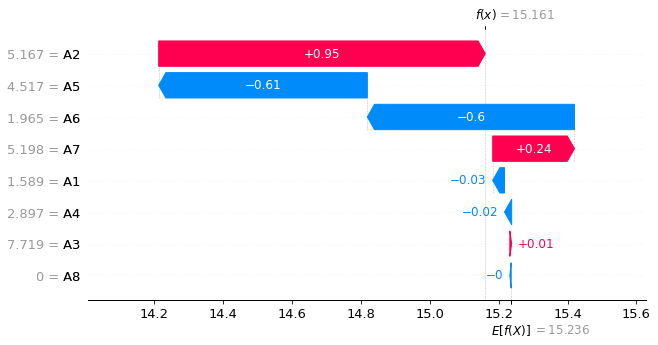

In [110]:
print('Null model (5-rand) of comparison')
watter_plot(type='dbac',simulation='5-rand')

Conditional interaction between activities 2-5


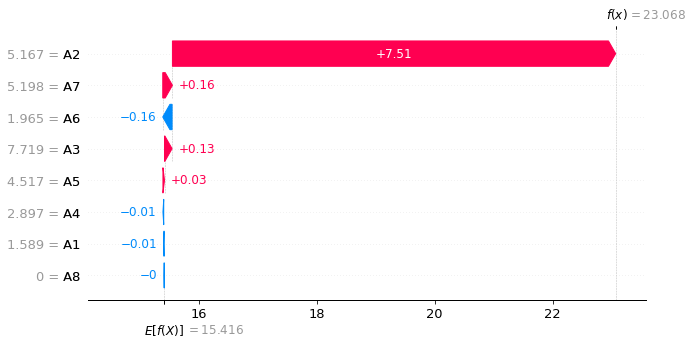

In [111]:
print('Conditional interaction between activities 2-5')
watter_plot(type='dbac',simulation='2-5')

### TB regression

Null model (5-rand) of comparison


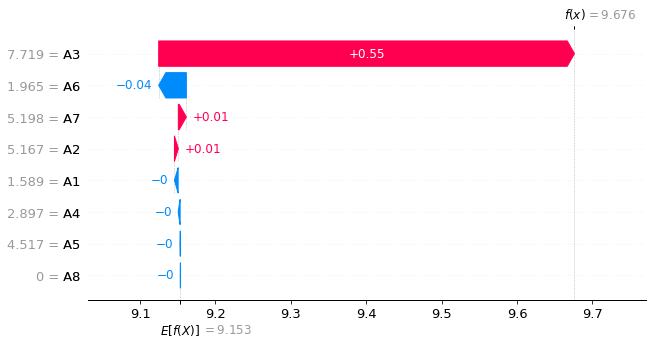

In [112]:
print('Null model (5-rand) of comparison')
watter_plot(type='tb',simulation='5-rand')

Conditional interaction between activities 2-5


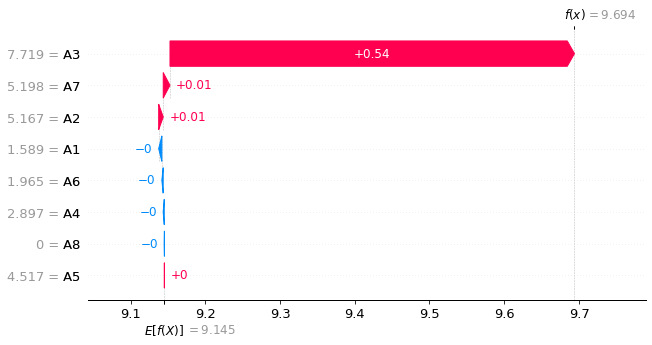

In [113]:
print('Conditional interaction between activities 2-5')
watter_plot(type='tb',simulation='2-5')